In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_enable_x64', True)

## Central difference

In [5]:
def diff_central(func=None, x=None, dx=None):
    return((func(x + 0.5 * dx) - func(x - 0.5 * dx)) / dx)

In [6]:
num = 10000
x = 10. * 2. * np.pi * (np.arange(num, dtype=np.float64) + 0.5) / np.float64(num)
f = np.sin(x) 
dfdx = diff_central(func=np.sin, x=x, dx=0.5 * 1.e-5)

Text(0, 0.5, 'f(x)')

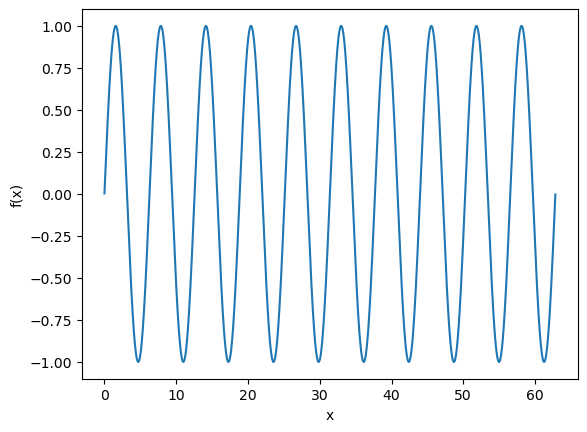

In [7]:
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')

Text(0, 0.5, 'df / dx')

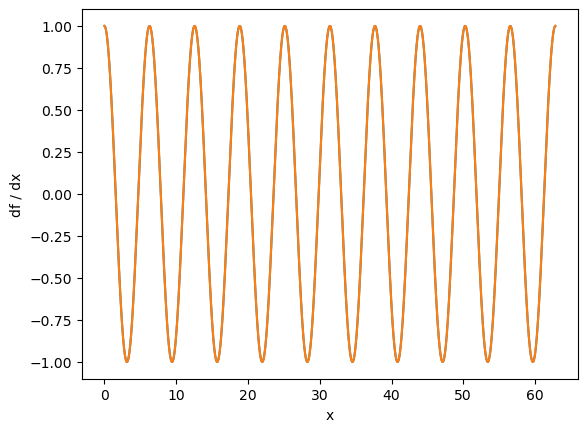

In [8]:
plt.plot(x, dfdx)
plt.plot(x, np.cos(x))
plt.xlabel('x')
plt.ylabel('df / dx')

Text(0, 0.5, 'Residual between estimate and actual df / dx')

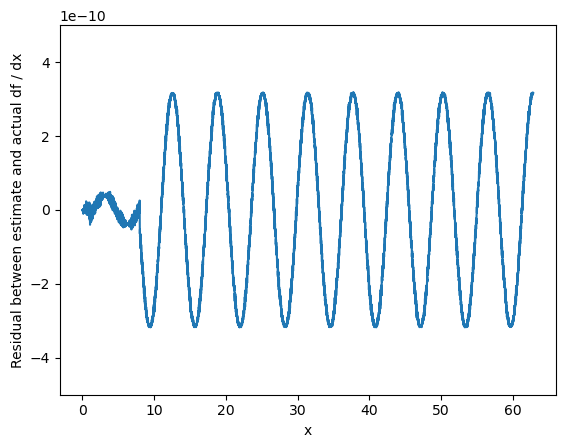

In [9]:
plt.plot(x, dfdx - np.cos(x))
plt.ylim((-0.5e-9, 0.5e-9))
plt.xlabel('x')
plt.ylabel('Residual between estimate and actual df / dx')

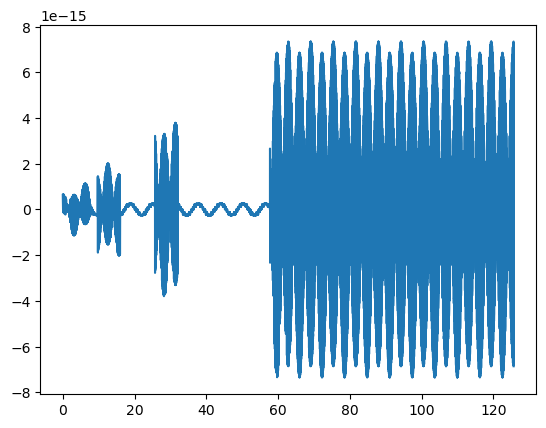

In [10]:
plt.plot(x * 2, np.sin(x * 2) - np.sin(x * 2 + np.pi * 2.))

## Higher order routines

In [11]:
def diff_correct(func=None, x=None, dx=None):
    return((4. * diff_central(func=func, x=x, dx=dx * 0.5) -
            diff_central(func=func, x=x, dx=dx)) / 3.)

In [12]:
num = 1000
x = 5 * 2. * np.pi * (np.arange(num, dtype=np.float64) + 0.5) / np.float64(num)
f = np.sin(x) 
dfdx = diff_correct(func=np.sin, x=x, dx=3.e-4)

Text(0, 0.5, 'Residual between estimate and actual df / dx')

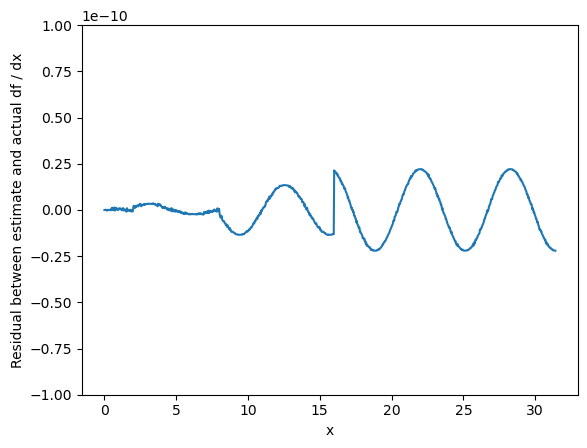

In [13]:
plt.plot(x, dfdx - np.cos(x))
plt.ylim((-1.e-10, 1.e-10))
plt.xlabel('x')
plt.ylabel('Residual between estimate and actual df / dx')

## Autodiff

Here is the simplest example of autodiff possible. Note that a better, longer set of descriptions and examples can be found in Kyle Cranmer's book: https://theoryandpractice.org/stats-ds-book/autodiff-tutorial.html

In [14]:
def f0(x):
    """Function f0
    
    Parameters
    ----------
    
    x : np.float64
        input value
        
    Returns
    -------
    
    f0 : np.float64
        output value
        
    Comment
    -------
    
    Returns x**2
"""
    return x**2

def f1(y):
    """Function f1
    
    Parameters
    ----------
    
    y : np.float64
        input value
        
    Returns
    -------
    
    f1 : np.float64
        output value
        
    Comment
    -------
    
    Returns sin(y)
"""
    return np.sin(y)

def f(x):
    """Function f
    
    Parameters
    ----------
    
    x : np.float64
        input value
        
    Returns
    -------
    
    f : np.float64
        output value
        
    Comment
    -------
    
    Returns f1(f0(x))
"""
    return(f1(f0(x)))

Text(0, 0.5, 'f(x)')

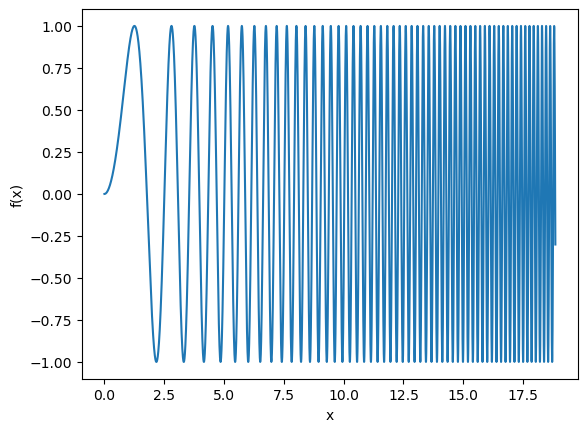

In [15]:
xlo = 0.
xhi = 3. * 2. * np.pi
nx = 10000
x = xlo + (xhi - xlo) * np.arange(nx, dtype=np.float64) / np.float64(nx - 1)

plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')

We can build the derivative into the function evaluations and track them through. Here we will do this "by hand" but of course the power of autodiff libraries will be that you won't have to do this. 

In [16]:
def f0_ad(x):
    """Function f0 with derivative returned
    
    Parameters
    ----------
    
    x : np.float64
        input value
        
    Returns
    -------
    
    f0 : np.float64
        output value
        
    df0dx : np.float64
        deriviative of output
        
    Comment
    -------
    
    Returns x**2, 2x
"""
    return x**2, 2 * x

def f1_ad(y):
    """Function f1 with derivative returned
    
    Parameters
    ----------
    
    y : np.float64
        input value
        
    Returns
    -------
    
    f1 : np.float64
        output value
        
    df1dx : np.float64
        deriviative of output
        
    Comment
    -------
    
    Returns sin(y), cos(y)
"""
    return np.sin(y), np.cos(y)

def f_ad(x):
    """Function f with derivative output
    
    Parameters
    ----------
    
    x : np.float64
        input value
        
    Returns
    -------
    
    f : np.float64
        output value
        
    dfdx : np.float64
        deriviative of output
        
    Comment
    -------
    
    Returns f1(f0(x))
"""
    v0, df0 = f0_ad(x)
    v, df1 = f1_ad(v0)
    return(v, df0 * df1)

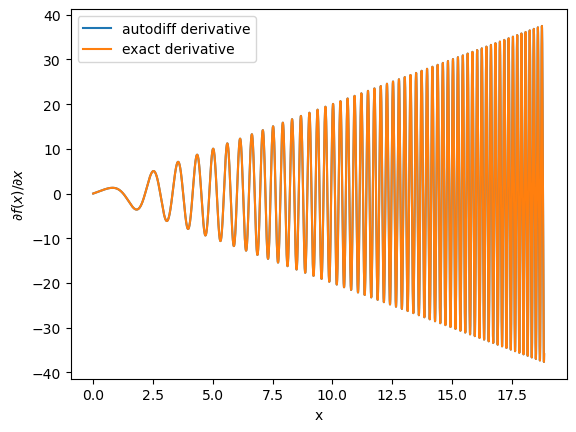

In [17]:
v, dv = f_ad(x)
plt.plot(x, dv, label='autodiff derivative')
plt.plot(x, 2. * x * np.cos(x**2), label='exact derivative')
plt.xlabel('x')
plt.ylabel('$\partial f(x) / \partial x$')
plt.legend()

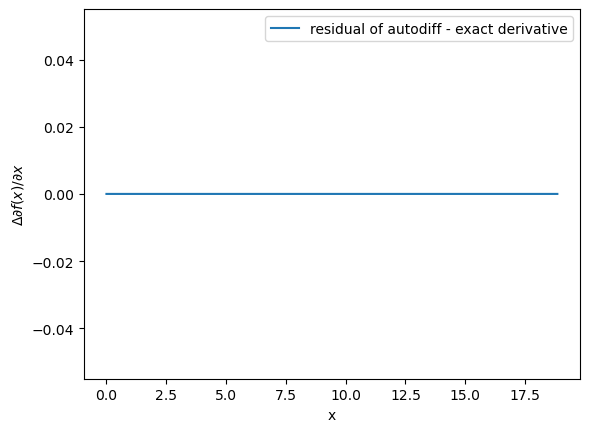

In [18]:
v, dv = f_ad(x)
plt.plot(x, dv - 2. * x * np.cos(x**2), label='residual of autodiff - exact derivative')
plt.xlabel('x')
plt.ylabel('$\Delta \partial f(x) / \partial x$')
plt.legend()

In [19]:
print(np.abs(dv - 2. * x * np.cos(x**2)).max())

0.0


This can also be extended to multiple variables. Here we use the example from Kyle Cranmer at the site referenced above:

$$z(x_1, x_2) = x_1 x_2 + x_2 = y + x_2$$

The operation itself can be expressed as:

In [20]:
def mul_func(x1,x2):
    return x1*x2

def sum_func(x1,x2):
    return x1+x2

def function(x):
    x1, x2 = x
    y = mul_func(x1, x2)
    z = sum_func(y, x2)
    return z

print(function([2,4]))

12


A version that performs autodiff can be written (VJP stands for "vector-Jacobian product" as defined in Kyle's notes). It first calculates the answer. Then it calls the derivative functions in reverse order. With an input <code>dz</code> (initialized to unity), each derivative call returns how each of its inputs responds to that <code>dz</code>. These sum through all of the functions to the response of the full set of parameters.

Note that you have to keep track of all the operations to run them backwards, and keep track of all the intermediate results (in this case <code>y</code>), but you only have to run the derivative functions backwards once.

In [21]:
def mul_vjp(x1, x2, dx1, dx2, dout):
    dx2 += dout * x1
    dx1 += dout * x2
    return dx1, dx2

def sum_vjp(x1, x2, dx1, dx2, dout):
    dx1 += dout * 1
    dx2 += dout * 1
    return dx1, dx2

def function_vjp(x, dz):
    
    # run forward
    x1,x2 = x
    y = mul_func(x1, x2)
    z = sum_func(y, x2)

    # zero gradients
    dy  = 0    
    dx1 = 0
    dx2 = 0
    
    # run backward
    dy, dx2  = sum_vjp(y, x1, dy, dx2, dz)
    dx1, dx2 = mul_vjp(x1, x2, dx1, dx2, dy)
    return z, [dx1, dx2]

In [22]:
print(function_vjp([2., 4.], 1.))

(12.0, [4.0, 3.0])


OK, this shouldn't be surprising when you look at it this way, since we're just doing exactly the calculation of the derivatives in these cases. But the power of looking at it this way is realizing that the chain rule here is straightforwardly (in principle at least) automated. If when you called np.cos() or any other operation it always passed along its known derivative, then you could just write code whose derivative was tracked automatically. This is "autodiff".

## Jax Implementation

Below is an example using jax, which shows the power of this, since the programmer doesn't need to track the derivatives themselves. Because the output derivative is just a linear function of all of the individual ones, this works well.

In [23]:
def f0_jax(x):
    """Function f0
    
    Parameters
    ----------
    
    x : np.float64
        input value
        
    Returns
    -------
    
    f0 : np.float64
        output value
        
    Comment
    -------
    
    Returns x**2; note no explicit jax-ness in this function.
"""
    return x**2

def f1_jax(y):
    """Function f1
    
    Parameters
    ----------
    
    y : np.float64
        input value
        
    Returns
    -------
    
    f1 : np.float64
        output value
        
    Comment
    -------
    
    Returns sin(y) (jax version)
"""
    return jnp.sin(y)

def f_jax(x):
    """Function f
    
    Parameters
    ----------
    
    x : np.float64
        input value
        
    Returns
    -------
    
    f : np.float64
        output value
        
    Comment
    -------
    
    Returns f1(f0(x))
"""
    return(f1_jax(f0_jax(x)))

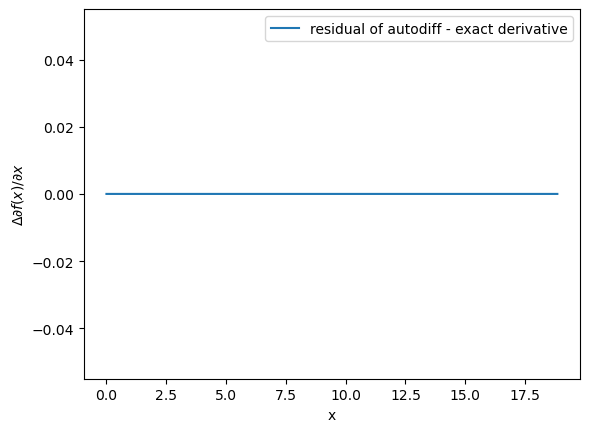

In [26]:
dv_jax = jax.grad(f_jax)
#  dv = dv_jax(x) <- this will fail because it expects a scalar
dv = jax.vmap(dv_jax)(x)  # but you can map the values into the function this way
plt.plot(x, dv - 2. * x * np.cos(x**2), label='residual of autodiff - exact derivative')
plt.xlabel('x')
plt.ylabel('$\Delta \partial f(x) / \partial x$')
plt.legend()

Higher order derivatives can also be done, because the derivatives are calculated using functions that are themselves differentiable. 

The second derivative of our function is:

$$2 \cos(x^2) - 4 x^2 \sin(x^2)$$

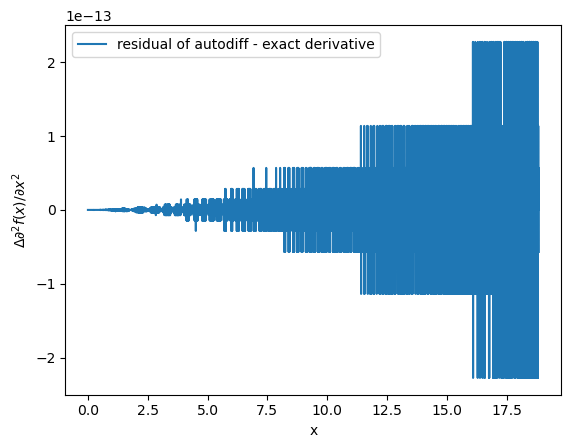

In [28]:
dv2_jax = jax.grad(dv_jax)
#  dv = dv_jax(x) <- this will fail because it expects a scalar
dv2 = jax.vmap(dv2_jax)(x)  # but you can map the values into the function this way
plt.plot(x, dv2 - (2. * np.cos(x**2) - 4 * x**2 * np.sin(x**2)), label='residual of autodiff - exact derivative')
plt.xlabel('x')
plt.ylabel('$\Delta \partial^2 f(x) / \partial x^2$')
plt.legend()

## More Realistic Multi-variable Example

The autodiff system is so general that you can do quite complicated functions. This is extremely important to modern techniques for optimization, where taking derivatives is highly advantageous. The following example demonstrates a more complicated situation.

In [29]:
def gaussian(x=None, y=None, xmean=0., ymean=0., pa=0., ba=1., smasig=1.):
    """Return 2D gaussian values
    
    Parameters
    ----------
    
    x : np.float64
        x values
    
    y : np.float64
        y values
         
    xmean : np.float64
        mean in x 
         
    ymean : np.float64
        mean in y
        
    pa : np.float64
        position angle of major axis (deg from + x towards +y)
        
    ba : np.float64
        minor over major axis ratio b/a
        
    smasig : np.float64
        sigma along semi-major axis
        
    Returns
    -------
    
    val : np.float64
         value of Gaussian
         
    Comments
    --------
    
    Calculates within jax
"""
    parad = pa / 180. * jnp.pi
    dx = x - xmean
    dy = y - ymean
    xp = dx * jnp.cos(parad) + dy * jnp.sin(parad)
    yp = (- dx * jnp.sin(parad) + dy * jnp.cos(parad)) / ba
    val = jnp.exp(- 0.5 * (xp**2 + yp**2) / smasig**2) / (2. * jnp.pi * smasig**2 * ba)
    return(val)

In [30]:
xlo = -3.
xhi = 3. 
nx = 50
x1 = xlo + (xhi - xlo) * np.arange(nx, dtype=np.float64) / np.float64(nx - 1)

ylo = -3.
yhi = 3.
ny = 50
y1 = ylo + (yhi - ylo) * np.arange(ny, dtype=np.float64) / np.float64(ny - 1)

x = np.outer(np.ones(ny), x1)
y = np.outer(y1, np.ones(nx))

In [31]:
sig = 1.
ba = 0.4
pa = 30.
xm = 0.
ym = 0.

In [32]:
cgaussian = lambda x, y : gaussian(x, y, xmean=xm, ymean=ym, ba=ba, pa=pa, smasig=sig)
val = jax.vmap(cgaussian)(x, y)

Text(0, 0.5, 'Y')

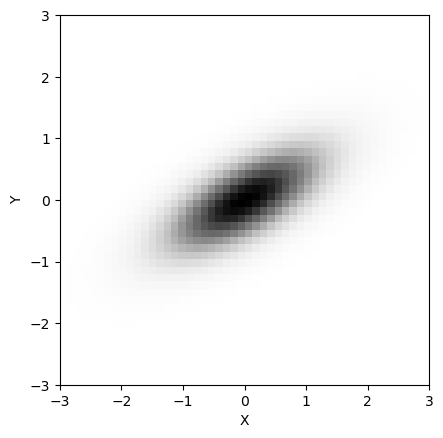

In [33]:
plt.imshow(val, origin='lower', cmap='Greys', extent=[xlo, yhi, ylo, yhi])
plt.xlabel('X')
plt.ylabel('Y')

In [34]:
dgaussian = jax.grad(gaussian, argnums=[0, 1, 2, 3, 4, 5, 6])

In [35]:
dfdx, dfdy, dfdxm, dfdym, dfdpa, dfdba, dfdsig = dgaussian(0., 0., xm, ym, pa, ba, sig)
print("df / dx = {v}".format(v=dfdx))
print("df / dy = {v}".format(v=dfdy))
print("df / d(xm) = {v}".format(v=dfdxm))
print("df / d(ym) = {v}".format(v=dfdym))
print("df / d(pa) = {v}".format(v=dfdpa))
print("df / d(ba) = {v}".format(v=dfdba))
print("df / d(sig) = {v}".format(v=dfdsig))

df / dx = 0.0
df / dy = -0.0
df / d(xm) = -0.0
df / d(ym) = 0.0
df / d(pa) = 0.0
df / d(ba) = -0.9947183943243458
df / d(sig) = -0.7957747154594766


In [36]:
dfdx, dfdy, dfdxm, dfdym, dfdpa, dfdba, dfdsig = dgaussian(0.5, 0.5, xm, ym, pa, ba, sig)
print("df / dx = {v}".format(v=dfdx))
print("df / dy = {v}".format(v=dfdy))
print("df / d(xm) = {v}".format(v=dfdxm))
print("df / d(ym) = {v}".format(v=dfdym))
print("df / d(pa) = {v}".format(v=dfdpa))
print("df / d(ba) = {v}".format(v=dfdba))
print("df / d(sig) = {v}".format(v=dfdsig))

df / dx = -0.0055599920380206
df / dy = -0.37803942812648894
df / d(xm) = 0.0055599920380206
df / d(ym) = 0.37803942812648894
df / d(pa) = 0.003250496277857781
df / d(ba) = -0.5609644555001999
df / d(sig) = -0.3757880020525541


In [40]:
dfdx, dfdy, dfdxm, dfdym, dfdpa, dfdba, dfdsig = \
    jax.vmap(dgaussian)(x.flatten(), y.flatten(),
                        jnp.zeros(x.size, dtype=np.float64),
                        jnp.zeros(x.size, dtype=np.float64),
                        jnp.zeros(x.size, dtype=np.float64) + pa,
                        jnp.zeros(x.size, dtype=np.float64) + ba,
                        jnp.zeros(x.size, dtype=np.float64) + sig)

Text(0, 0.5, 'Y')

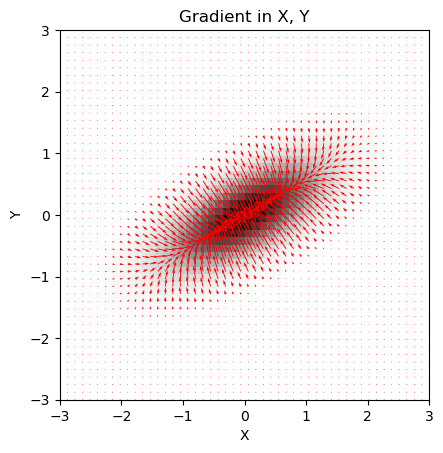

In [41]:
plt.imshow(val, origin='lower', cmap='Greys', extent=[xlo, yhi, ylo, yhi])
plt.quiver(x.flatten(), y.flatten(),
           dfdx, dfdy,
           angles = 'xy',
           scale = 8., color='red')
plt.title('Gradient in X, Y')
plt.xlabel('X')
plt.ylabel('Y')

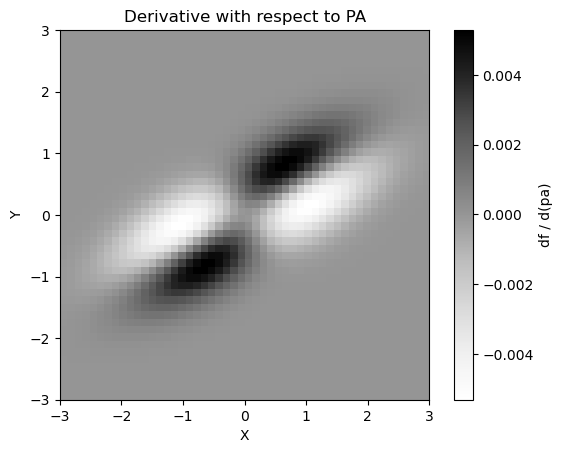

In [42]:
plt.imshow(dfdpa.reshape(nx, ny), origin='lower', cmap='Greys', extent=[xlo, yhi, ylo, yhi])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Derivative with respect to PA')
plt.colorbar(label='df / d(pa)')

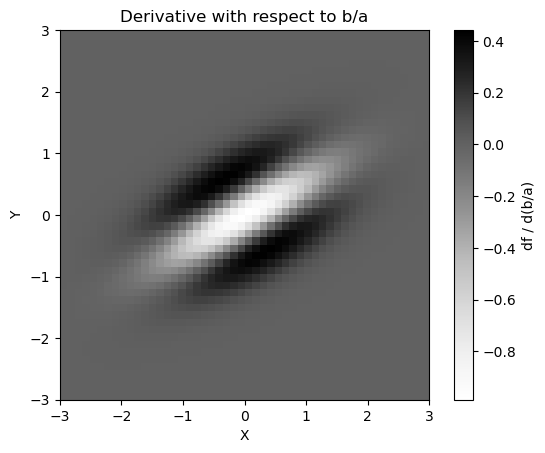

In [43]:
plt.imshow(dfdba.reshape(nx, ny), origin='lower', cmap='Greys', extent=[xlo, yhi, ylo, yhi])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Derivative with respect to b/a')
plt.colorbar(label='df / d(b/a)')

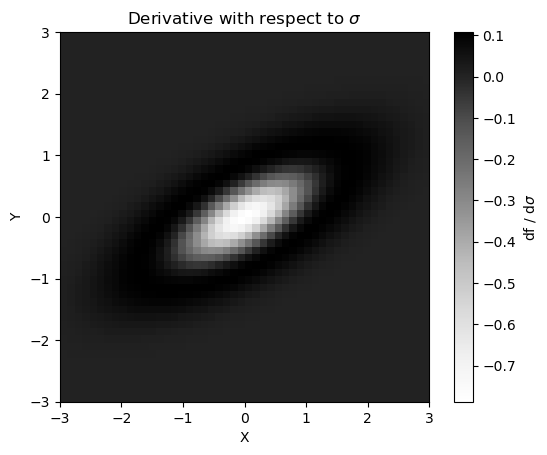

In [44]:
plt.imshow(dfdsig.reshape(nx, ny), origin='lower', cmap='Greys', extent=[xlo, yhi, ylo, yhi])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Derivative with respect to $\sigma$')
plt.colorbar(label='df / d$\sigma$')